In [1]:
#### detect hardware
from google.colab import drive
drive.mount('/content/drive/')

#### check for gpu
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    print(local_device_protos)

get_available_gpus()
##################################

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15752904801725361226
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16183459840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6314931825310128448
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [2]:
!pip install tqdm efficientnet_pytorch torchsummary torch-lr-finder

In [322]:
!7z x /content/drive/MyDrive/logoSim/train_and_test.zip -odata\


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/logoSim/                                         1 file, 1579235829 bytes (1507 MiB)

Extracting archive: /content/drive/MyDrive/logoSim/train_and_test.zip
  2% 4096 Open               71% 122880 Open                --
Path = /content/drive/MyDrive/logoSim/train_and_test.zip
Type = zip
Physical Size = 1579235829
64-bit = +

  0%    
Would you like to replace the existing file:
  Path:     data/train_and_test/test/Accessories/24seven/12.jpg
  Size:     7604 bytes (8 KiB)
  Modified: 2020-03-03 14:59:48
with the file from archive:
  Path:     train_and_test/test/Accessories/24seven

In [83]:
root = '/content/data/train_and_test'
trainPath = root + '/train'
testPath = root + '/test'

In [84]:
import numpy as np
import glob
import os
import time
import torch
import cv2
import torchvision
import matplotlib.pyplot as plt
import tqdm.notebook as tq

from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
from torchsummary import summary
from torch_lr_finder import LRFinder
from efficientnet_pytorch import EfficientNet

In [85]:
####VARS
batch_size=256
H,W = 128,128
epochs = 10

In [86]:
print(trainPath)
print(testPath)

/content/data/train_and_test/train
/content/data/train_and_test/test


In [87]:
fileList = glob.glob(trainPath + '/**/*.jpg', recursive=True) + glob.glob(testPath + '/**/*.jpg', recursive=True)
print(len(fileList))

167140


In [88]:
train, val = glob.glob(trainPath + '/**/*.jpg', recursive=True) , glob.glob(testPath + '/**/*.jpg', recursive=True)
#train_test_split(fileList[:2500], test_size=0.2, random_state=777)
print(len(train))
print(len(val))

116958
50182


In [106]:
class LogoDataset(Dataset):

    def __init__(self, fileList, transform=None, train=True):
        self.fileList = fileList
        self.transform = transform
        self.train = train

        self.labels = np.array([x.split('/')[-2] for x in self.fileList])
        self.labelset = set([x.split('/')[-2] for x in self.fileList])
        self.label_to_idx = {label: np.where(label == self.labels) for label in self.labelset}

        random_state = np.random.RandomState(777)
        self.triplets = []

        for i in range(len(self.fileList)):
          label1 = self.fileList[i].split('/')[-2]
          idx1 = random_state.choice(self.label_to_idx[label1][0])
          negLabel =np.random.choice(list(self.labelset - set(label1)))
          negIdx = random_state.choice(self.label_to_idx[negLabel][0])
          self.triplets.append([i, idx1, negIdx])

    def __len__(self):
        return len(self.fileList)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
          idx = idx.tolist()

        '''
        if self.train:
          label = self.fileList[idx].split('/')[-2]
          posIdx = idx
          while posIdx == idx:
            posIdx = np.random.choice(self.label_to_idx[label][0])
          negLabel = np.random.choice(list(self.labelset - set([label])))
          negIdx   = np.random.choice(self.label_to_idx[negLabel][0])

          img1 = self.fileList[idx]
          img2 = self.fileList[posIdx]
          img3 = self.fileList[negIdx]
          
        else:
        '''
        img1 = self.fileList[self.triplets[idx][0]]
        img2 = self.fileList[self.triplets[idx][1]]
        img3 = self.fileList[self.triplets[idx][2]]


        img_name = self.fileList[idx]
        img1 = Image.open(img1).convert("RGB")
        img2 = Image.open(img2).convert("RGB")
        img3 = Image.open(img3).convert("RGB")

        if self.transform is not None:
          img1 = self.transform(img1)
          img2 = self.transform(img2)
          img3 = self.transform(img3)


        return img1, img2, img3

In [107]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((H,W)),
        torchvision.transforms.ToTensor(),
])

In [108]:
trainDataset = LogoDataset(train, transform=transform, train=True)
valDataset = LogoDataset(val, transform=transform, train=False)

trainLoader = DataLoader(trainDataset, batch_size=batch_size, num_workers=4, pin_memory=True)
valLoader = DataLoader(valDataset, batch_size=batch_size, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])


AssertionError: ignored

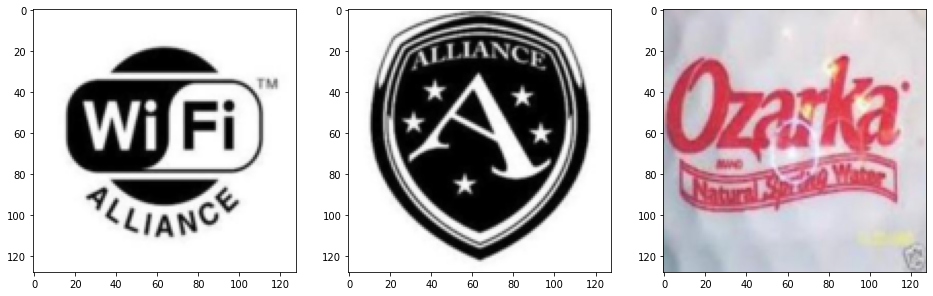

In [109]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 16))
for x,y,z in trainLoader:
  print(x[0].shape)
  print(y[0].shape)
  print(z[0].shape)
  axes[0].imshow(x[0].permute(1,2,0))
  axes[1].imshow(y[0].permute(1,2,0))
  axes[2].imshow(z[0].permute(1,2,0))
  assert 0

In [110]:
class TripleNet(torch.nn.Module):
    
    def __init__(self):
        super(TripleNet, self).__init__()
        self.basemodel = EfficientNet.from_name('efficientnet-b0', include_top=False)

        for param in self.basemodel.parameters():
            param.requires_grad = False

        self.latent1  = torch.nn.Linear(1280, 256)
        self.latent2  = torch.nn.Linear(256, 128)
        self.lrelu = torch.nn.LeakyReLU(0.3)

    def get_features(self,img):
        x = self.basemodel(img)
          
        x = x.view(x.size()[0], 1280)
        x = self.lrelu(self.latent1(x))
        x = self.lrelu(self.latent2(x))
        return x

    def forward(self, x,y,z):

        o1 = self.get_features(x)
        o2 = self.get_features(y)
        o3 = self.get_features(z)
 
        return o1, o2, o3

In [111]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
summary(TripleNet().to(device), [(3, 128, 128), (3, 128, 128), (3, 128, 128)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 129, 129]               0
Conv2dStaticSamePadding-2           [-1, 32, 64, 64]             864
       BatchNorm2d-3           [-1, 32, 64, 64]              64
MemoryEfficientSwish-4           [-1, 32, 64, 64]               0
         ZeroPad2d-5           [-1, 32, 66, 66]               0
Conv2dStaticSamePadding-6           [-1, 32, 64, 64]             288
       BatchNorm2d-7           [-1, 32, 64, 64]              64
MemoryEfficientSwish-8           [-1, 32, 64, 64]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

In [112]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TripleNet().to(device)
criterion = torch.nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
#############find LR
from torch_lr_finder import TrainDataLoaderIter

class MyTrainDataLoaderIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        x,y,z = batch_data
        return x,y,z

trainloader_wrapper = MyTrainDataLoaderIter(trainLoader)

optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(trainloader_wrapper, end_lr=100, num_iter=100)
lr_finder.plot()
lr_finder.reset()

In [113]:
history = {}
history['trainLoss'] = []
history['valLoss'] = []

In [114]:
!mkdir model

mkdir: cannot create directory ‘model’: File exists


In [115]:
for epoch in range(epochs):
    start_time = time.time()
    avg_loss = 0.

    optimizer.zero_grad()

    for i, (x,y,z) in enumerate(tq.tqdm(trainLoader)):

        x = x.to(device)
        #print(images.shape)
        y = y.to(device)
        #print(target.shape)
        z = z.to(device)
        f1,f2,f3 = model(x,y,z)
        #print(target_pred.shape)
        loss = criterion(f1,f2,f3)
        #print(loss)

        avg_loss += loss.item()
        
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = avg_loss / len(trainLoader)
    history['trainLoss'].append(avg_loss)
    avg_val_loss = 0.

    for i, (x,y,z) in enumerate(tq.tqdm(valLoader)):

        x = x.to(device)
        #print(images.shape)
        y = y.to(device)
        #print(target.shape)
        z = z.to(device)

        with torch.no_grad():
            f1,f2,f3 = model(x,y,z)

        loss = criterion(f1,f2,f3)
        avg_val_loss += loss.item()
    avg_val_loss = avg_val_loss / len(valLoader)

    if epoch % 5 == 0:
      torch.save(model.state_dict(), '/content/model/model_' + str(epoch) + '_epochs.pt')

    history['valLoss'].append(avg_val_loss)
    elapsed = time.time() - start_time
    print(f'  Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f} time: {elapsed:.0f}s')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


KeyboardInterrupt: ignored

In [318]:
torch.save(model.state_dict(), '/content/model/model_10epochs.pt')

[0.8041845650067736, 0.7452456150326218, 0.6437624564447341, 0.58122209267165, 0.507282748508636, 0.44426847322634067, 0.40439945982292264, 0.39926563059051134, 0.35269995237123913, 0.33444818471205834]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


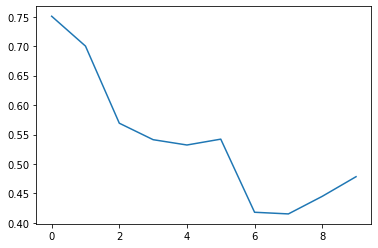

In [320]:
print(history['trainLoss'])
print(list(range(0,len(history['trainLoss']))))
ids = list(range(0,len(history['valLoss'])))
plt.plot(ids, history['valLoss'])
